### Main Analysis

##### Look at time trends and analyze various metrics of perforamance and strategy based evaluation methods 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy
import pandas as pd
import os
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE 
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [2]:
# Load in local csv
folder = '/root/capsule/data/filtered_data_20240911/filtered_data_20240911.csv'
df = pd.read_csv(folder)

df.head()

,subject_id,session_date,nwb_suffix,session,rig,user_name,curriculum_name,curriculum_version,current_stage_actual,task,...,water_after_session_last_session,location,session_name,creation_time,subject_genotype,probes,results,results_location,session_time,docDB_status
0,730942,2024-09-10,181826,14.0,447-3-D,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
1,741211,2024-09-10,181707,14.0,447-3-C,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,NaN,s3://aind-private-data-prod-o5171v/behavior_74...,behavior_741211_2024-09-10_18-17-07,2024-09-10T18:17:07-07:00,wt/wt,[],NaN,NaN,18-17-07,1_uploaded but not processed
2,736198,2024-09-10,181446,14.0,447-2-C,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,NaN,s3://aind-private-data-prod-o5171v/behavior_73...,behavior_736198_2024-09-10_18-14-46,2024-09-10T18:14:46-07:00,wt/wt,[],NaN,NaN,18-14-46,1_uploaded but not processed
3,730945,2024-09-10,181112,14.0,447-2-B,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
4,741213,2024-09-10,180831,14.0,447-2-A,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,NaN,s3://aind-private-data-prod-o5171v/behavior_74...,behavior_741213_2024-09-10_18-08-31,2024-09-10T18:08:31-07:00,wt/wt,[],NaN,NaN,18-08-31,1_uploaded but not processed


In [17]:
# Check dimensions and content of dataframe for variables of interest: 

# Find all instances of unique subject ids
ids = df['subject_id'].unique()

# Find total stage count
num_stage = df['current_stage_actual'].unique()
stages = df['current_stage_actual']

# Find total foraging efficiency value count 
forag_eff_count = df['foraging_eff']

# Find total dates assigned per foraging efficiency score 
session_date_count = df['session_date'].unique()

# Find total number of unique tasks and labels: 
task_count = df['task'].unique()

print(f'Types of tasks: {task_count}, number of unique tasks: {len(task_count)}')

print(f'number of unique ids: {len(ids)}')

print(f'types of stages: {num_stage}, number of total stages {len(stages)}')

print(f'number of assigned dates {len(session_date_count)}')

print(f'number of forag eff scores: {len(forag_eff_count)}')

Types of tasks: ['Uncoupled Baiting' 'Coupled Baiting' 'Uncoupled Without Baiting'
 'Coupled Without Baiting' 'RewardN'], number of unique tasks: 5
number of unique ids: 183
types of stages: ['GRADUATED' 'STAGE_3' 'STAGE_1_WARMUP' 'STAGE_1' 'STAGE_FINAL' 'STAGE_2'
 'STAGE_4' nan], number of total stages 3763
number of assigned dates 283
number of forag eff scores: 3763


In [4]:
# Create new foraging efficiency df
fe_df = df[['subject_id', 'current_stage_actual','session_date','task','foraging_eff']]

print(fe_df.shape)
fe_df.head()

(3763, 5)


,subject_id,current_stage_actual,session_date,task,foraging_eff
0,730942,GRADUATED,2024-09-10,Uncoupled Baiting,0.761435
1,741211,GRADUATED,2024-09-10,Uncoupled Baiting,0.768945
2,736198,GRADUATED,2024-09-10,Uncoupled Baiting,0.708424
3,730945,GRADUATED,2024-09-10,Uncoupled Baiting,0.722345
4,741213,GRADUATED,2024-09-10,Uncoupled Baiting,0.740106


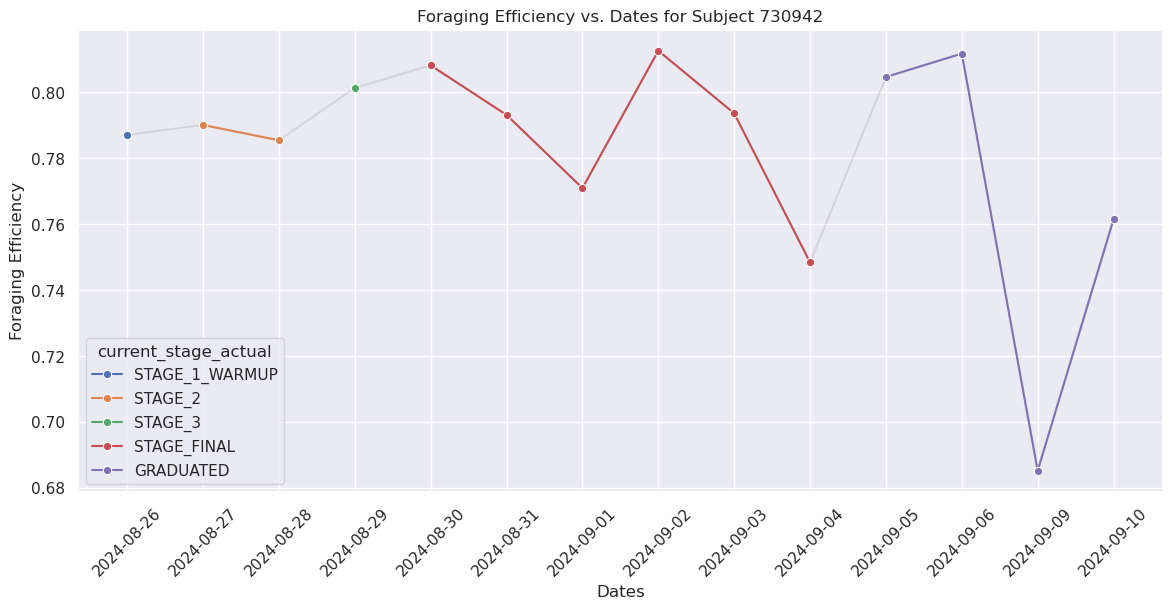

In [5]:
# Plotting for 1 subject id over corresponding dates 

subject_id = 730942

# Filter for selected subject id and create new dataframe for only that subject id
fe_df_filtered = fe_df[fe_df['subject_id'] == subject_id]

fe_df_filtered = fe_df_filtered.sort_values(by='session_date', ascending=True)

sns.set_theme()

plt.figure(figsize=(14, 6))

plt.plot(fe_df_filtered['session_date'], fe_df_filtered['foraging_eff'], color='grey', alpha=0.2, zorder=1)

sns.lineplot(data=fe_df_filtered, x='session_date', y='foraging_eff', hue='current_stage_actual', marker='o', zorder=2)

plt.xlabel('Dates')
plt.ylabel('Foraging Efficiency')
plt.title(f'Foraging Efficiency vs. Dates for Subject {subject_id}')
plt.xticks(rotation = 45)
plt.grid(True)

plt.show()

##### Cumulative analysis

In [6]:
# Create design matrices for all task types 

# Get unique stages and subjects
stages = fe_df['current_stage_actual'].unique()
subjects = fe_df['subject_id'].unique()

stage_arrays = {}

for stage in stages:
    # Filter the dataframe for the current stage
    stage_df = fe_df[fe_df['current_stage_actual'] == stage]
    
    # Get the max number of sessions for this stage
    max_sessions = stage_df.groupby('subject_id').size().max()
    
    # For the NaN stage
    if pd.isna(max_sessions):
        print(f"No data found for stage {stage}")
        continue
    
    max_sessions = int(max_sessions)
    
    stage_array = np.full((len(subjects), max_sessions), np.nan)
    
    # Fill the array with foraging efficiency scores
    for i, subject in enumerate(subjects):
        subject_data = stage_df[stage_df['subject_id'] == subject]['foraging_eff'].values
        stage_array[i, :len(subject_data)] = subject_data
    
    stage_arrays[stage] = stage_array

for stage, array in stage_arrays.items():
    print(f"Stage {stage}: Array shape = {array.shape}")

No data found for stage nan
Stage GRADUATED: Array shape = (183, 22)
Stage STAGE_3: Array shape = (183, 23)
Stage STAGE_1_WARMUP: Array shape = (183, 2)
Stage STAGE_1: Array shape = (183, 9)
Stage STAGE_FINAL: Array shape = (183, 34)
Stage STAGE_2: Array shape = (183, 14)
Stage STAGE_4: Array shape = (183, 10)


In [16]:
# Get unique stages, subjects, and tasks

stages = fe_df['current_stage_actual'].unique()
subjects = fe_df['subject_id'].unique()
tasks = fe_df['task'].unique()

# Initialize new dictionary 
stage_task_arrays = {}

for stage in stages:
    for task in tasks:
        # Filter the dataframe for the current stage and task
        stage_task_df = fe_df[(fe_df['current_stage_actual'] == stage) & (fe_df['task'] == task)]
        
        max_sessions = stage_task_df.groupby('subject_id').size().max()
        
        # For stages or tasks with no data
        if pd.isna(max_sessions):
            print(f"No data found for stage {stage} and task {task}")
            continue
        
        max_sessions = int(max_sessions)
        
        stage_task_array = np.full((len(subjects), max_sessions), np.nan)
        
        # Fill the array with fe scores
        for i, subject in enumerate(subjects):
            subject_data = stage_task_df[stage_task_df['subject_id'] == subject]['foraging_eff'].values
            stage_task_array[i, :len(subject_data)] = subject_data
        
        stage_task_arrays[(stage, task)] = stage_task_array

for (stage, task), array in stage_task_arrays.items():
    print(f"Stage {stage}, Task {task}: Array shape = {array.shape}")

No data found for stage GRADUATED and task Coupled Without Baiting
No data found for stage GRADUATED and task RewardN
No data found for stage STAGE_3 and task RewardN
No data found for stage STAGE_1_WARMUP and task Uncoupled Baiting
No data found for stage STAGE_1_WARMUP and task Uncoupled Without Baiting
No data found for stage STAGE_1_WARMUP and task Coupled Without Baiting
No data found for stage STAGE_1_WARMUP and task RewardN
No data found for stage STAGE_1 and task Uncoupled Baiting
No data found for stage STAGE_1 and task Uncoupled Without Baiting
No data found for stage STAGE_1 and task RewardN
No data found for stage STAGE_FINAL and task RewardN
No data found for stage STAGE_2 and task Uncoupled Baiting
No data found for stage STAGE_2 and task Uncoupled Without Baiting
No data found for stage STAGE_2 and task RewardN
No data found for stage STAGE_4 and task Coupled Baiting
No data found for stage STAGE_4 and task Coupled Without Baiting
No data found for stage STAGE_4 and task

In [24]:
# Create readable table of above data for task, stage, fe counts

count_data = []

for stage in stages:
    for task in tasks:
        # Filter the dataframe for the current stage and task
        stage_task_df = fe_df[(fe_df['current_stage_actual'] == stage) & (fe_df['task'] == task)]
        
        # Count the number of scores for this stage and task
        count = stage_task_df['foraging_eff'].count()
        
        # Append the count to list
        count_data.append({
            'Stage': stage,
            'Task': task,
            'Count': count
        })

# Create the DataFrame from the list of count data
count_df = pd.DataFrame(count_data)

# Pivot the DataFrame to create a table with stages as rows and tasks as columns
result_table = count_df.pivot(index='Stage', columns='Task', values='Count')

# Convert NaNs to 0s
result_table = result_table.fillna(0).astype(int)

# Add a Total for both rows and columns
result_table.loc['Total'] = result_table.sum()
result_table['Total'] = result_table.sum(axis=1)

print(result_table)

Task            Coupled Baiting  Coupled Without Baiting  RewardN  \
Stage                                                               
NaN                           0                        0        0   
GRADUATED                    44                        0        0   
STAGE_1                     141                        1        0   
STAGE_1_WARMUP               95                        0        0   
STAGE_2                     129                      175        0   
STAGE_3                      69                      128        0   
STAGE_4                       0                        0        0   
STAGE_FINAL                 126                        1        0   
Total                       604                      305        0   

Task            Uncoupled Baiting  Uncoupled Without Baiting  Total  
Stage                                                                
NaN                             0                          0      0  
GRADUATED                     

In [7]:
# Function to adjust outliers in each stage 

def remove_outliers(stage_arrays, n):
    result = {}
    for stage, array in stage_arrays.items():
        # Count non-NaN values in each row
        non_nan_counts = np.sum(~np.isnan(array), axis=1)
        
        # Sort rows by their non-NaN counts
        sorted_indices = np.argsort(non_nan_counts)[::-1]
        sorted_counts = non_nan_counts[sorted_indices]
        
        # Identify the cutoff point
        if len(sorted_counts) > n:
            cutoff = sorted_counts[n]
        else:
            cutoff = sorted_counts[-1]
        
        # Create a mask for rows to keep
        keep_mask = non_nan_counts <= cutoff
        
        # For rows with counts > cutoff, we'll trim them to match the cutoff
        trim_mask = non_nan_counts > cutoff
        
        # Create the new array
        new_array = np.full((array.shape[0], cutoff), np.nan)
        
        # Fill in the rows that are kept entirely
        new_array[keep_mask] = array[keep_mask][:, :cutoff]
        
        # Fill in the trimmed rows
        for i in np.where(trim_mask)[0]:
            non_nan_indices = np.where(~np.isnan(array[i]))[0][:cutoff]
            new_array[i, :len(non_nan_indices)] = array[i, non_nan_indices]
        
        result[stage] = new_array
    
    return result


In [28]:
# Set prefrence for outlier removal 

n = 3

# Non-task specific dict
filtered_arrays = remove_outliers(stage_arrays, n)

# Task specific dict
filtered_stage_task_arrays = remove_outliers(stage_task_arrays, n)

In [26]:
# Compare adjustements

def compare_dictionaries(original, filtered):
    comparison = {}
    
    for stage in original.keys():
        orig_array = original[stage]
        filt_array = filtered[stage]
        
        orig_count = np.sum(~np.isnan(orig_array))
        filt_count = np.sum(~np.isnan(filt_array))
        removed_count = orig_count - filt_count
        
        comparison[stage] = {
            "original_count": orig_count,
            "filtered_count": filt_count,
            "removed_count": removed_count,
            "removal_percentage": (removed_count / orig_count) * 100 if orig_count > 0 else 0
        }
        
        if removed_count > 0:
            removed_mask = np.isin(orig_array, filt_array, invert=True)
            removed_values = orig_array[removed_mask]
            comparison[stage]["removed_values_summary"] = {
                "min": np.nanmin(removed_values),
                "max": np.nanmax(removed_values),
                "mean": np.nanmean(removed_values),
                "median": np.nanmedian(removed_values)
            }
    
    return comparison

def print_comparison_summary(comparison):
    for stage, data in comparison.items():
        print(f"Stage: {stage}")
        print(f"  Original count: {data['original_count']}")
        print(f"  Filtered count: {data['filtered_count']}")
        print(f"  Removed count: {data['removed_count']}")
        print(f"  Removal percentage: {data['removal_percentage']:.2f}%")
        if 'removed_values_summary' in data:
            print("  Removed values summary:")
            for key, value in data['removed_values_summary'].items():
                print(f"    {key}: {value}")
        print()

In [30]:
comparison_results = compare_dictionaries(stage_arrays, filtered_arrays)

print_comparison_summary(comparison_results)


Stage: GRADUATED
  Original count: 238
  Filtered count: 226
  Removed count: 12
  Removal percentage: 5.04%
  Removed values summary:
    min: 0.5438959503399349
    max: 0.8112909593367547
    mean: 0.6910798797266015
    median: 0.7089585651586281

Stage: STAGE_3
  Original count: 343
  Filtered count: 323
  Removed count: 20
  Removal percentage: 5.83%
  Removed values summary:
    min: 0.6560134566862909
    max: 0.8841705751980868
    mean: 0.7667332570627134
    median: 0.7566319933341751

Stage: STAGE_1_WARMUP
  Original count: 95
  Filtered count: 92
  Removed count: 3
  Removal percentage: 3.16%
  Removed values summary:
    min: 0.0
    max: 0.7196969696969698
    mean: 0.4461279461279462
    median: 0.6186868686868687

Stage: STAGE_1
  Original count: 142
  Filtered count: 138
  Removed count: 4
  Removal percentage: 2.82%
  Removed values summary:
    min: 0.528681506849315
    max: 0.6802120141342757
    mean: 0.5971073749301815
    median: 0.5897679893685677

Stage: STAG

In [31]:
comparison_results_1 = compare_dictionaries(stage_task_arrays, filtered_stage_task_arrays)

print_comparison_summary(comparison_results_1)

Stage: ('GRADUATED', 'Uncoupled Baiting')
  Original count: 112
  Filtered count: 102
  Removed count: 10
  Removal percentage: 8.93%
  Removed values summary:
    min: 0.5469835430080883
    max: 0.8828633899744771
    mean: 0.7464124819790378
    median: 0.7513185214845286

Stage: ('GRADUATED', 'Coupled Baiting')
  Original count: 44
  Filtered count: 20
  Removed count: 24
  Removal percentage: 54.55%
  Removed values summary:
    min: 0.58820146527541
    max: 0.9414843416025426
    mean: 0.7793196943366221
    median: 0.7677569573816307

Stage: ('GRADUATED', 'Uncoupled Without Baiting')
  Original count: 82
  Filtered count: 54
  Removed count: 28
  Removal percentage: 34.15%
  Removed values summary:
    min: 0.4827586206896552
    max: 0.8482370975983647
    mean: 0.7074979724054115
    median: 0.7191472208453713

Stage: ('STAGE_3', 'Uncoupled Baiting')
  Original count: 44
  Filtered count: 43
  Removed count: 1
  Removal percentage: 2.27%
  Removed values summary:
    min: 0.5

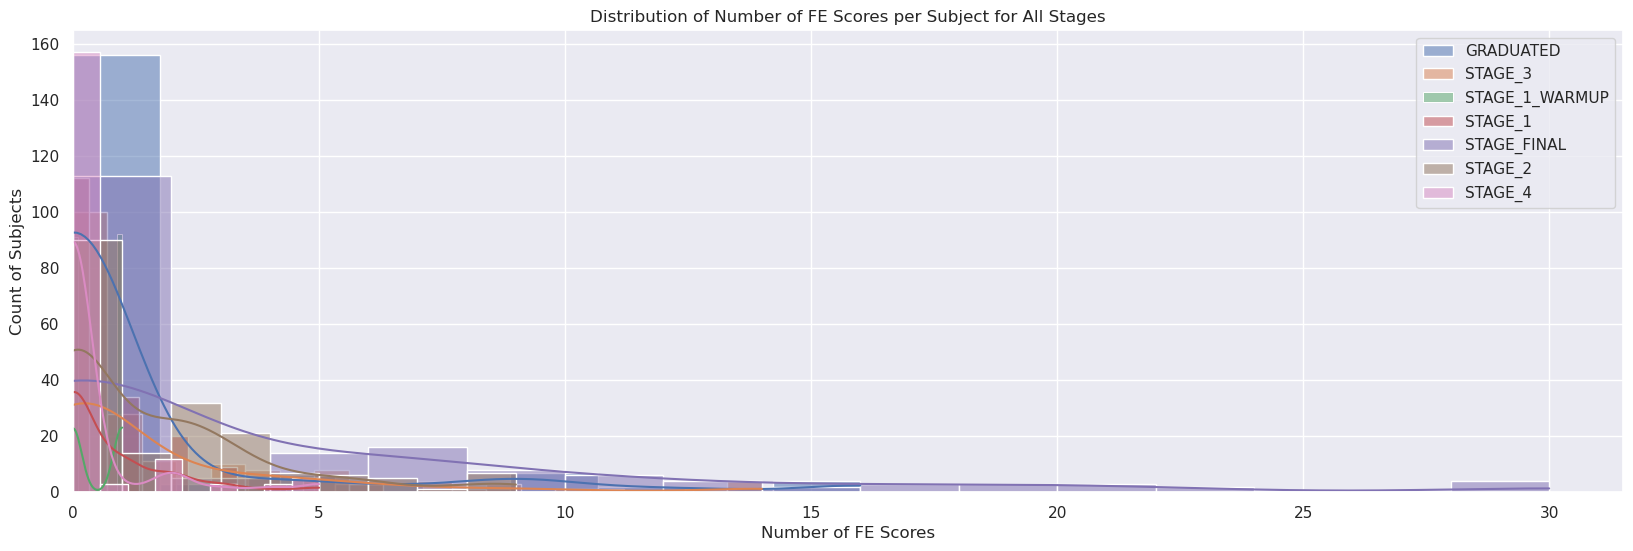


Summary for GRADUATED:
IQR: 4.800000000000011
Mean number of scores: 1.23
Min number of scores: 0
Max number of scores: 16
Number of outliers: 5
Outliers:
Subject 21: 16 scores
Subject 36: 13 scores
Subject 42: 16 scores
Subject 56: 16 scores
Subject 103: 16 scores

Summary for STAGE_3:
IQR: 5.0
Mean number of scores: 1.77
Min number of scores: 0
Max number of scores: 14
Number of outliers: 5
Outliers:
Subject 34: 13 scores
Subject 76: 14 scores
Subject 79: 14 scores
Subject 80: 14 scores
Subject 89: 14 scores

Summary for STAGE_1_WARMUP:
IQR: 1.0
Mean number of scores: 0.50
Min number of scores: 0
Max number of scores: 1
Number of outliers: 0

Summary for STAGE_1:
IQR: 2.0
Mean number of scores: 0.75
Min number of scores: 0
Max number of scores: 5
Number of outliers: 0

Summary for STAGE_FINAL:
IQR: 12.0
Mean number of scores: 3.99
Min number of scores: 0
Max number of scores: 30
Number of outliers: 0

Summary for STAGE_2:
IQR: 4.800000000000011
Mean number of scores: 1.62
Min number

In [10]:
# Count non-NaN values for each subject after adjustment

plt.figure(figsize=(20, 6))

for stage, array in filtered_arrays.items():
    non_nan_counts = np.sum(~np.isnan(array), axis=1)
    sns.histplot(non_nan_counts, kde=True, label=stage)

plt.title('Distribution of Number of FE Scores per Subject for All Stages')
plt.xlabel('Number of FE Scores')
plt.ylabel('Count of Subjects')
plt.xlim(left=0)
plt.legend()
plt.show()

# Summary statistics for each array
for stage, array in filtered_arrays.items():

    non_nan_counts = np.sum(~np.isnan(array), axis=1)

    Q1 = np.percentile(non_nan_counts, 10)
    Q3 = np.percentile(non_nan_counts, 90)
    IQR = Q3 - Q1
    upper_bound = Q3 + (1.5 * IQR)
    outliers = non_nan_counts[(non_nan_counts > upper_bound)]
    outlier_idx = np.where((non_nan_counts > upper_bound))[0]

    print(f"\nSummary for {stage}:")
    print(f'IQR: {IQR}')
    print(f"Mean number of scores: {np.mean(non_nan_counts):.2f}")
    print(f"Min number of scores: {np.min(non_nan_counts)}")
    print(f"Max number of scores: {np.max(non_nan_counts)}")
    print(f'Number of outliers: {len(outliers)}')
    if len(outliers) > 0:
        print('Outliers:')
        for idx, value in zip(outlier_idx, outliers):
            print(f'Subject {idx}: {value} scores')

In [35]:
summary_data = []

for (stage, task), array in stage_task_arrays.items():
    non_nan_counts = np.sum(~np.isnan(array), axis=1)
    
    Q1 = np.percentile(non_nan_counts, 25)
    Q3 = np.percentile(non_nan_counts, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    outliers = non_nan_counts[(non_nan_counts < lower_bound) | (non_nan_counts > upper_bound)]
    
    summary_data.append({
        'Stage': stage,
        'Task': task,
        'Mean': np.mean(non_nan_counts),
        'Median': np.median(non_nan_counts),
        'Std Dev': np.std(non_nan_counts),
        'Min': np.min(non_nan_counts),
        'Max': np.max(non_nan_counts),
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Outliers': len(outliers)
    })

# Create a summary DataFrame
summary_df = pd.DataFrame(summary_data)

print("\nOverall Summary Statistics:")
print(summary_df.to_string(index=False))


Overall Summary Statistics:
         Stage                      Task     Mean  Median  Std Dev  Min  Max  Q1  Q3  IQR  Outliers
     GRADUATED         Uncoupled Baiting 0.612022     0.0 2.199669    0   16 0.0 0.0  0.0        18
     GRADUATED           Coupled Baiting 0.240437     0.0 1.754652    0   18 0.0 0.0  0.0         4
     GRADUATED Uncoupled Without Baiting 0.448087     0.0 2.591766    0   22 0.0 0.0  0.0         8
       STAGE_3         Uncoupled Baiting 0.240437     0.0 0.633409    0    4 0.0 0.0  0.0        30
       STAGE_3           Coupled Baiting 0.377049     0.0 1.923373    0   23 0.0 0.0  0.0        18
       STAGE_3 Uncoupled Without Baiting 0.557377     0.0 2.542693    0   22 0.0 0.0  0.0        14
       STAGE_3   Coupled Without Baiting 0.699454     0.0 2.165893    0   14 0.0 0.0  0.0        23
STAGE_1_WARMUP           Coupled Baiting 0.519126     1.0 0.531433    0    2 0.0 1.0  1.0         0
       STAGE_1           Coupled Baiting 0.770492     0.0 1.310655    0

In [11]:
# Create heatmap for example array in dictionary 

def plot_array_heatmap(array, stage):
    plt.figure(figsize=(16,5))
    plt.imshow(array, cmap='viridis', aspect='auto')
    plt.colorbar(label='Foraging Efficiency')
    plt.title(f'Foraging Efficiency Heatmap for {stage}')
    plt.xlabel('Session Index')
    plt.ylabel('Subject Index')
    plt.show()

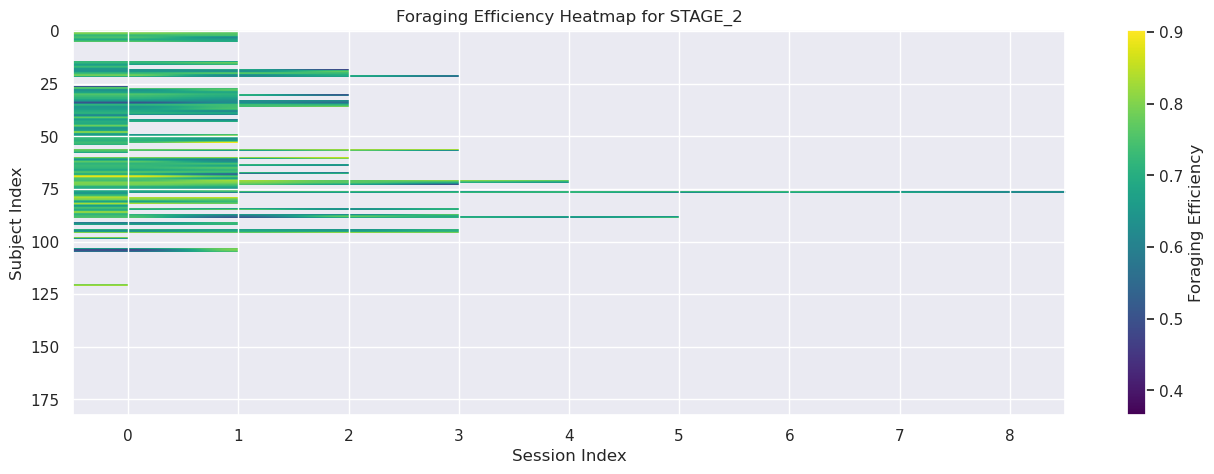

In [12]:
# Plot example array for visualization
plot_array_heatmap(filtered_arrays['STAGE_2'], 'STAGE_2')

In [13]:
# Calculate averages for each array

stage_averages = {}

for stage, array in filtered_arrays.items():
    # Calculate the mean along axis 0 (across subjects)
    # nan_mean ignores NaN values in the calculation
    stage_average = np.nanmean(array, axis=0)
    stage_averages[stage] = stage_average

# Print the average vectors
for stage, average_vector in stage_averages.items():
    print(f"\nAverage foraging efficiency for {stage}:")
    print(average_vector)
    print(f"Shape: {average_vector.shape}")



Average foraging efficiency for GRADUATED:
[0.74374592 0.75717365 0.77008181 0.78134111 0.74092198 0.7182318
 0.7290697  0.76569463 0.78323345 0.74559313 0.80113646 0.72359173
 0.77962249 0.70519477 0.63398157 0.7606773 ]
Shape: (16,)

Average foraging efficiency for STAGE_3:
[0.70950537 0.70064734 0.6693356  0.66531728 0.66631463 0.68652435
 0.65444517 0.71206736 0.66387157 0.70242539 0.67208542 0.75864257
 0.70102762 0.75101831]
Shape: (14,)

Average foraging efficiency for STAGE_1_WARMUP:
[0.67517862]
Shape: (1,)

Average foraging efficiency for STAGE_1:
[0.69723067 0.65326004 0.66055988 0.59127028 0.58516925]
Shape: (5,)

Average foraging efficiency for STAGE_FINAL:
[0.75414797 0.72682649 0.72921487 0.73623829 0.74668073 0.74124177
 0.74572922 0.73217935 0.72386442 0.76313443 0.76979669 0.7332907
 0.74240561 0.7376977  0.72455611 0.74497687 0.72366256 0.72926771
 0.76913893 0.71555013 0.69563847 0.76317552 0.84241517 0.72711026
 0.75825136 0.74731153 0.76091044 0.67654011 0.715130

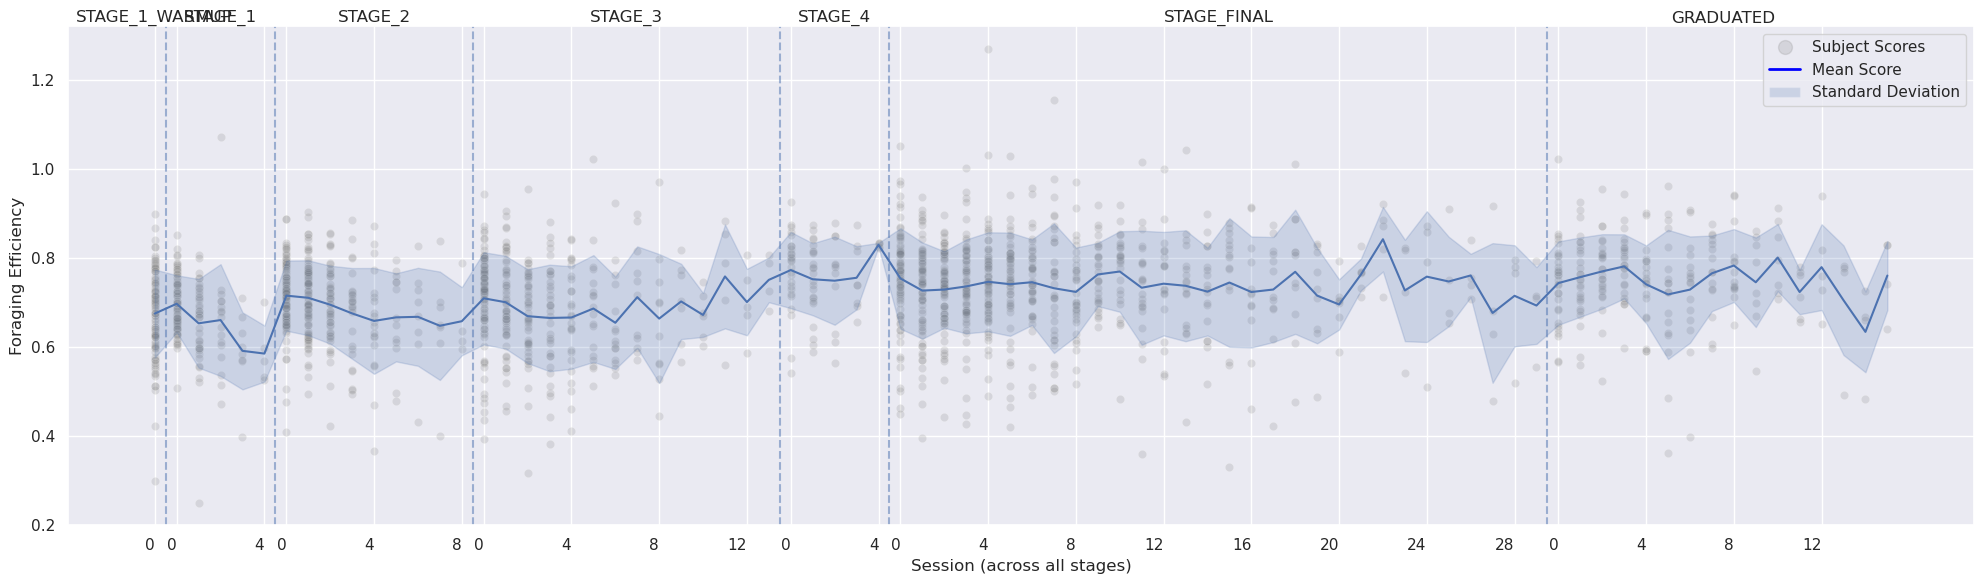


STAGE_1_WARMUP:
Number of Sessions: 1
Mean foraging efficiency: 0.68
Standard deviation: nan
Min efficiency: 0.68
Max efficiency: 0.68

STAGE_1:
Number of Sessions: 5
Mean foraging efficiency: 0.64
Standard deviation: 0.05
Min efficiency: 0.59
Max efficiency: 0.70

STAGE_2:
Number of Sessions: 9
Mean foraging efficiency: 0.68
Standard deviation: 0.02
Min efficiency: 0.65
Max efficiency: 0.72

STAGE_3:
Number of Sessions: 14
Mean foraging efficiency: 0.69
Standard deviation: 0.03
Min efficiency: 0.65
Max efficiency: 0.76

STAGE_4:
Number of Sessions: 5
Mean foraging efficiency: 0.77
Standard deviation: 0.03
Min efficiency: 0.75
Max efficiency: 0.83

STAGE_FINAL:
Number of Sessions: 30
Mean foraging efficiency: 0.74
Standard deviation: 0.03
Min efficiency: 0.68
Max efficiency: 0.84

GRADUATED:
Number of Sessions: 16
Mean foraging efficiency: 0.75
Standard deviation: 0.04
Min efficiency: 0.63
Max efficiency: 0.80


In [14]:
# Plot average fe values over dates 

stage_sequence = ['STAGE_1_WARMUP', 'STAGE_1', 'STAGE_2', 'STAGE_3', 'STAGE_4', 'STAGE_FINAL', 'GRADUATED']

# Prepare data for plotting
data = []
subject_data = []
overall_session = 0

for stage in stage_sequence:
    if stage in filtered_arrays:
        stage_data = filtered_arrays[stage]
        num_sessions = stage_data.shape[1]
        num_subjects = stage_data.shape[0]
        
        for session in range(num_sessions):
            session_data = stage_data[:, session]
            mean = np.nanmean(session_data)
            std = np.nanstd(session_data)
            
            data.append({
                'Stage': stage,
                'Session': overall_session,
                'Stage Session': session,
                'Mean': mean,
                'Std': std
            })
            
            for subject in range(num_subjects):
                subject_data.append({
                    'Stage': stage,
                    'Session': overall_session,
                    'Stage Session': session,
                    'Subject': subject,
                    'Score': stage_data[subject, session]
                })

            overall_session += 1
    else:
        print(f" {stage} not found in the data.")

# Create plotting dataframe 
stage_plot_df = pd.DataFrame(data)
subject_plot_df = pd.DataFrame(subject_data)

plt.figure(figsize=(20, 6))

# Plotting Function
sns.scatterplot(x='Session', y='Score', data=subject_plot_df, alpha=0.2, color='grey', legend=False)
sns.lineplot(x='Session', y='Mean', data=stage_plot_df)


plt.fill_between(stage_plot_df['Session'], 
                stage_plot_df['Mean'] - stage_plot_df['Std'], 
                stage_plot_df['Mean'] + stage_plot_df['Std'], 
                alpha=0.2, color='b')


plt.xlabel('Session (across all stages)', fontsize=12)
plt.ylabel('Foraging Efficiency', fontsize=12)

stage_boundaries = [stage_plot_df[stage_plot_df['Stage'] == stage]['Session'].min() for stage in stage_sequence[1:]]
for boundary in stage_boundaries:
    plt.axvline(x=boundary - 0.5, color='b', linestyle='--', alpha=0.5)

xticks = []
xticklabels = []
for i, stage in enumerate(stage_sequence):
    if stage in filtered_arrays:
        stage_sessions = stage_plot_df[stage_plot_df['Stage'] == stage]['Session']
        stage_start = stage_sessions.min()
        stage_end = stage_sessions.max()
        stage_ticks = range(int(stage_start), int(stage_end) + 1, 4)
        xticks.extend(stage_ticks)
        xticklabels.extend(range(0, (len(stage_ticks) - 1) * 4 + 1, 4))

        mid_point = (stage_start + stage_end) / 2
        plt.text(mid_point, plt.ylim()[1], stage, horizontalalignment='center', verticalalignment='bottom')

plt.xticks(xticks, xticklabels)
plt.xticks(ha='right')
plt.xlim()

# Add legend
plt.plot([], [], color='grey', alpha=0.2, linewidth=0, marker='o', markersize=10, label='Subject Scores')
plt.plot([], [], color='blue', linewidth=2, label='Mean Score')
plt.fill_between([], [], alpha=0.2, label='Standard Deviation')
plt.legend()


plt.tight_layout()
plt.show()

# Basic statistics for each stage 
for stage in stage_sequence:
    if stage in filtered_arrays:
        stage_data = stage_plot_df[stage_plot_df['Stage'] == stage]
        print(f'\n{stage}:')
        print(f'Number of Sessions: {len(stage_data)}')
        print(f"Mean foraging efficiency: {stage_data['Mean'].mean():.2f}")
        print(f"Standard deviation: {stage_data['Mean'].std():.2f}")
        print(f"Min efficiency: {stage_data['Mean'].min():.2f}")
        print(f"Max efficiency: {stage_data['Mean'].max():.2f}")